In [9]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import malaya
import random
import re
import string
from pprint import pprint
from statistics import mean
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

sia = SentimentIntensityAnalyzer()
mly = malaya.sentiment.multinomial()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

df = pd.read_csv('datasets/duck_training.csv')
df = df.replace(-1, 'negative')
df = df.replace(0, 'neutral')
df = df.replace(1, 'positive')
df = df[df['TweetSentiment'] != 'neutral']

df2 = pd.read_csv('datasets/student_tweet_training.csv')

df3 = pd.read_csv('datasets/malay_dataset_twitter_training.csv')
df3 = df3[df3['TweetSentiment'] != 'neutral']

dfs = [df, df2, df3]
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe

tweets_df = df['TweetText']
positive_tweets = np.array(tweets_df[df['TweetSentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[df['TweetSentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    #removes hyperlinks and twitter mentions
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    #removes hyperlinks and twitter mentions
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    
positive_word_top_100 = [word for word, count in positive_fd.most_common(100)]
negative_word_top_100 = [word for word, count in negative_fd.most_common(100)]

learned_positive_words = [word for word in positive_fd]
learned_negative_words = [word for word in negative_fd]

#positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in positive_words_raw
    #if word.isalpha() and word not in unwanted
#])

#negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in negative_words_raw
    #if word.isalpha() and word not in unwanted
#])

#np.save('data/positive_word_top_100', positive_word_top_100)
#np.save('data/negative_word_top_100', negative_word_top_100)
#np.save('data/learned_words', learned_words)
#np.save('data/learned_positive_words', learned_positive_words)
#np.save('data/learned_negative_words', learned_negative_words)

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    learned_positive_words_frequency = 0
    learned_negative_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    word_tokens = set(nltk.word_tokenize(tweet))

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1

            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1

            if word.lower() in learned_positive_words:
                learned_positive_words_frequency += 1
            if word.lower() in learned_negative_words:
                learned_negative_words_frequency += 1

        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    features["learned_positive_words_frequency"] = learned_positive_words_frequency
    features["learned_negative_words_frequency"] = learned_negative_words_frequency

    return features

training_dataset = [
    (get_features(tweet), "positive")
    for tweet in positive_tweets
]
training_dataset.extend([
    (get_features(tweet), "negative")
    for tweet in negative_tweets
])

training_count = len(training_dataset) // 5
random.shuffle(training_dataset)

classifiers = {
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "SVMClassifier" : SVC(),
}

for classifier_name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)

    print(F"\nTraining {classifier_name} model...")
    print(F"Training sample size: {len(training_dataset)-training_count}")
    classifier.train(training_dataset[:len(training_dataset)-training_count])

    print(F"Testing {classifier_name} model...")
    print(F"Testing sample size: {training_count}")
    accuracy = nltk.classify.accuracy(classifier, training_dataset[len(training_dataset)-training_count:])

    print(F"{classifier_name} - Accuracy: {accuracy:.2%}")
    pickle.dump(classifier, open(F"models/{classifier_name}.pickle", 'wb'))


Training MultinomialNB model...
Training sample size: 1414
Testing MultinomialNB model...
Testing sample size: 353
MultinomialNB - Accuracy: 95.47%

Training KNeighborsClassifier model...
Training sample size: 1414
Testing KNeighborsClassifier model...
Testing sample size: 353
KNeighborsClassifier - Accuracy: 95.75%

Training DecisionTreeClassifier model...
Training sample size: 1414
Testing DecisionTreeClassifier model...
Testing sample size: 353
DecisionTreeClassifier - Accuracy: 94.90%

Training RandomForestClassifier model...
Training sample size: 1414
Testing RandomForestClassifier model...
Testing sample size: 353
RandomForestClassifier - Accuracy: 95.47%

Training LogisticRegression model...
Training sample size: 1414
Testing LogisticRegression model...
Testing sample size: 353
LogisticRegression - Accuracy: 95.75%

Training MLPClassifier model...
Training sample size: 1414
Testing MLPClassifier model...
Testing sample size: 353
MLPClassifier - Accuracy: 95.75%

Training SVMCla

Multinomial NB 

Training Accuracy scores: [0.96178344 0.96107573 0.96534653 0.96746818 0.96817539]
Mean Training Accuracy: 96.47698527814566
Training Precision scores: [0.97984496 0.98130841 0.98151002 0.98159509 0.98015267]
Mean Training Precision: 0.9808822303287699
Training Recall scores: [0.93907875 0.93610698 0.94510386 0.9495549  0.95252226]
Mean Training Recall: 0.9444733488829413
Training F1 scores: [0.95902883 0.9581749  0.96296296 0.9653092  0.96613995]
Mean Training F1 Score: 0.9623231709850989
Validation Accuracy scores: [0.98022599 0.97740113 0.9631728  0.95184136 0.95184136]
Mean Validation Accuracy: 96.48965285446775
Validation Precision scores: [0.99390244 0.97633136 0.98136646 0.97484277 0.98089172]
Mean Validation Precision: 0.981466949327857
Validation Recall scores: [0.96449704 0.97633136 0.94047619 0.92261905 0.91666667]
Mean Validation Recall: 0.9441180614257538
Validation F1 scores: [0.97897898 0.97633136 0.96048632 0.94801223 0.94769231]
Mean Validation F1 Scor

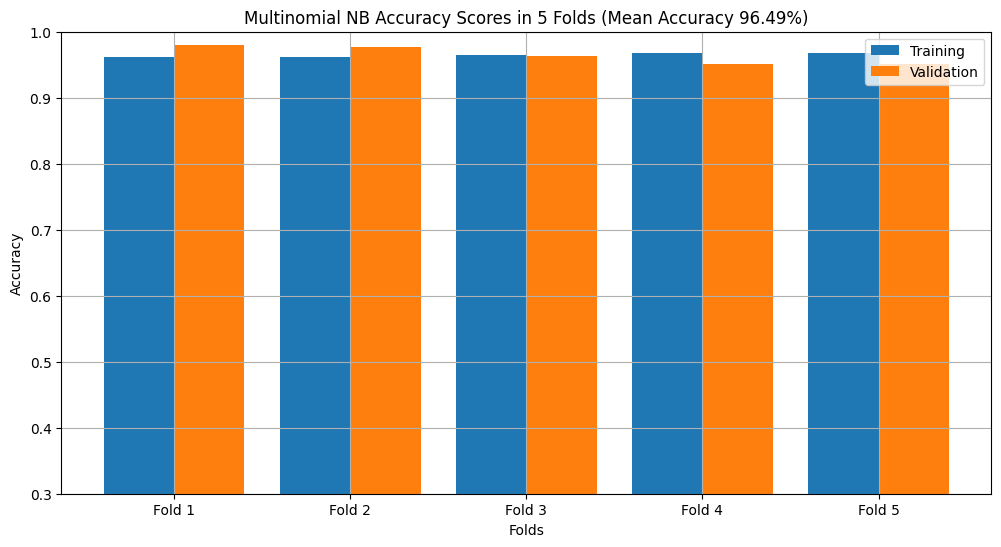

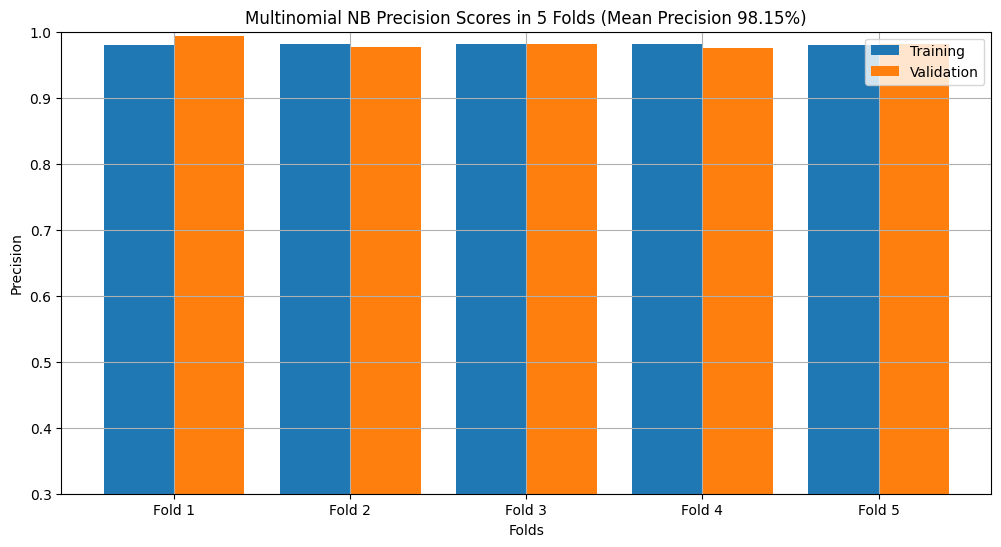

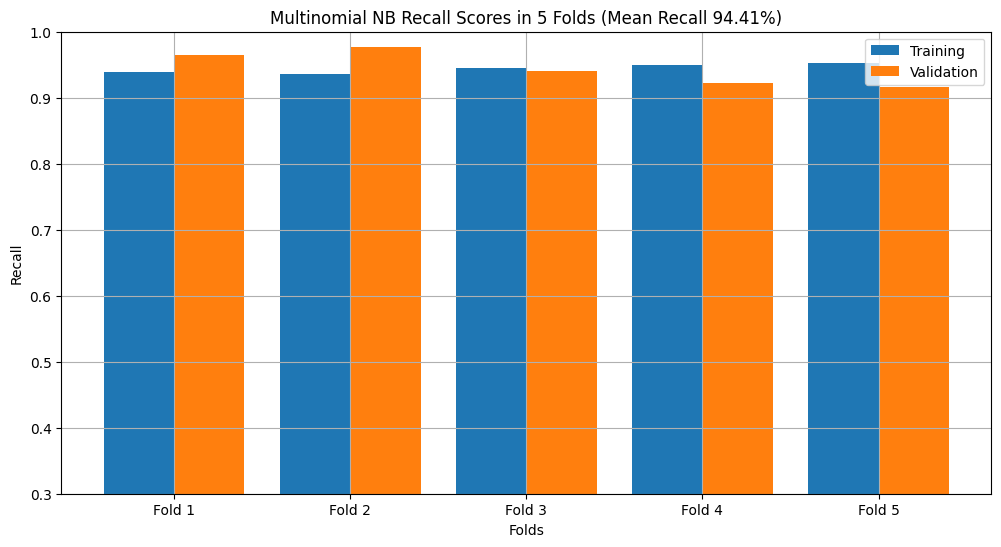

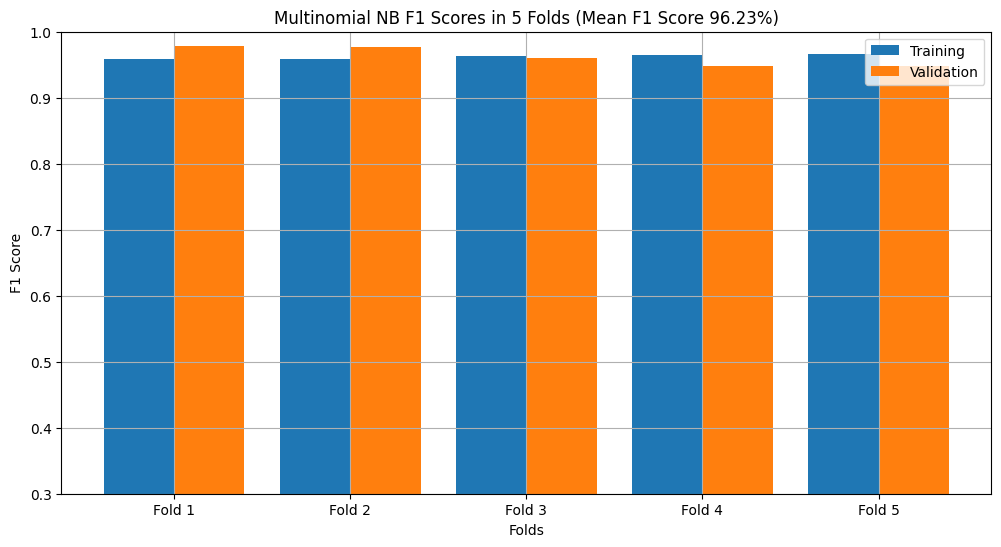

K Nearest Neighbors 

Training Accuracy scores: [0.97169144 0.96886058 0.9688826  0.97524752 0.97595474]
Mean Training Accuracy: 97.21273765229115
Training Precision scores: [0.97593985 0.96731055 0.96735905 0.97615499 0.97337278]
Mean Training Precision: 0.972027444691961
Training Recall scores: [0.96433878 0.96731055 0.96735905 0.97181009 0.97626113]
Mean Training Recall: 0.9694159196828938
Training F1 scores: [0.97010463 0.96731055 0.96735905 0.9739777  0.97481481]
Mean Training F1 Score: 0.9707133487972172
Validation Accuracy scores: [0.96610169 0.97457627 0.96600567 0.95184136 0.95750708]
Mean Validation Accuracy: 96.3206414750084
Validation Precision scores: [0.95375723 0.96511628 0.96428571 0.9689441  0.94736842]
Mean Validation Precision: 0.9598943478441043
Validation Recall scores: [0.97633136 0.98224852 0.96428571 0.92857143 0.96428571]
Mean Validation Recall: 0.9631445477599325
Validation F1 scores: [0.96491228 0.97360704 0.96428571 0.94832827 0.95575221]
Mean Validation F1 

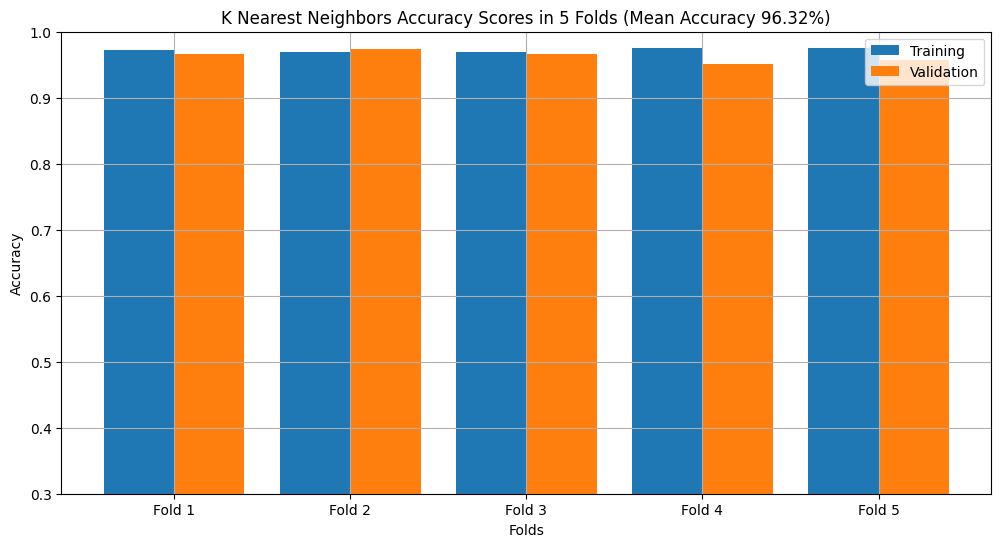

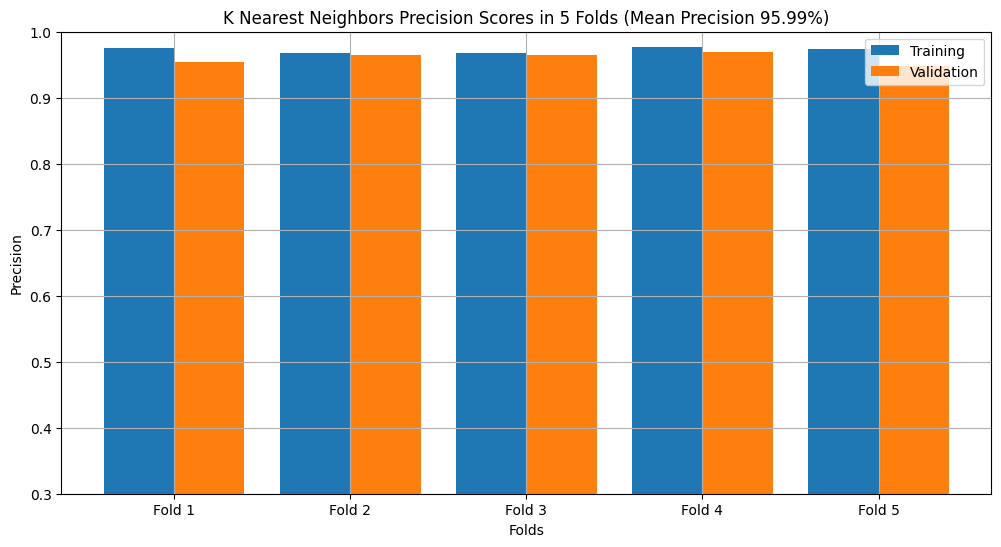

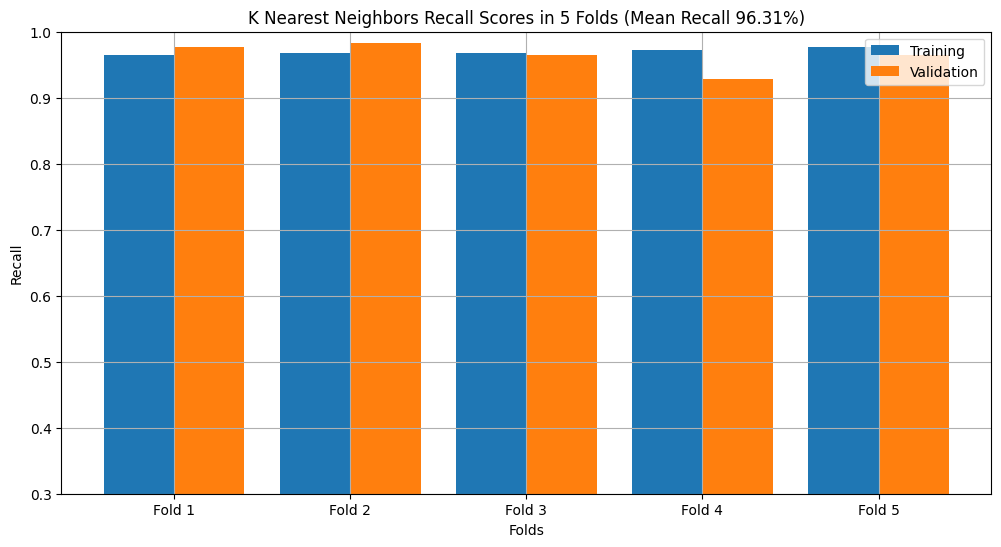

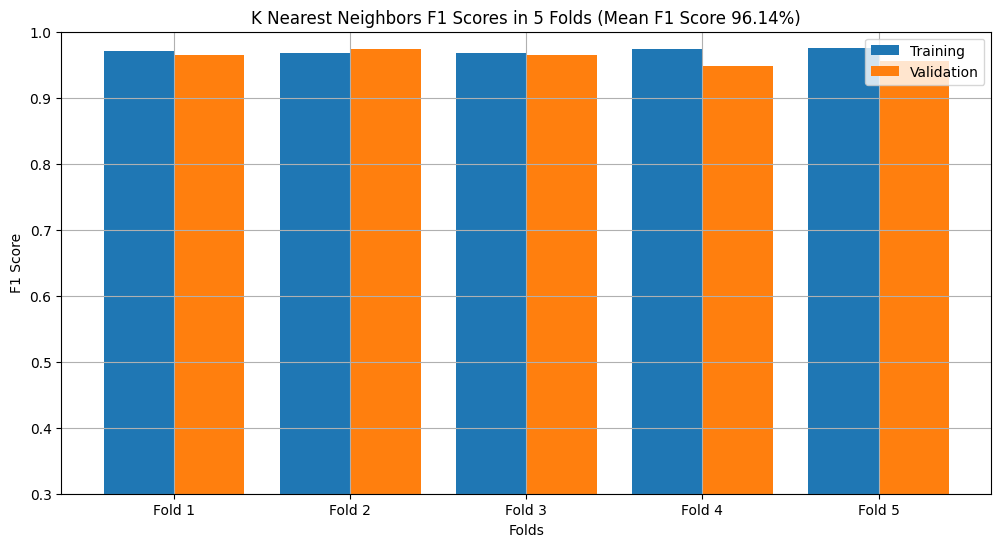

Decision Tree 

Training Accuracy scores: [1.         0.99929229 0.99929279 0.99929279 1.        ]
Mean Training Accuracy: 99.95755717518978
Training Precision scores: [1. 1. 1. 1. 1.]
Mean Training Precision: 1.0
Training Recall scores: [1.         0.99851412 0.99851632 0.99851632 1.        ]
Mean Training Recall: 0.9991093513697029
Training F1 scores: [1.         0.99925651 0.99925761 0.99925761 1.        ]
Mean Training F1 Score: 0.9995543449162809
Validation Accuracy scores: [0.94915254 0.96045198 0.96033994 0.9631728  0.95467422]
Mean Validation Accuracy: 95.75582977225076
Validation Precision scores: [0.92655367 0.95321637 0.95833333 0.97546012 0.96341463]
Mean Validation Precision: 0.9553956273528904
Validation Recall scores: [0.9704142  0.96449704 0.95833333 0.94642857 0.94047619]
Mean Validation Recall: 0.9560298675683292
Validation F1 scores: [0.94797688 0.95882353 0.95833333 0.96072508 0.95180723]
Mean Validation F1 Score: 0.9555332091604358


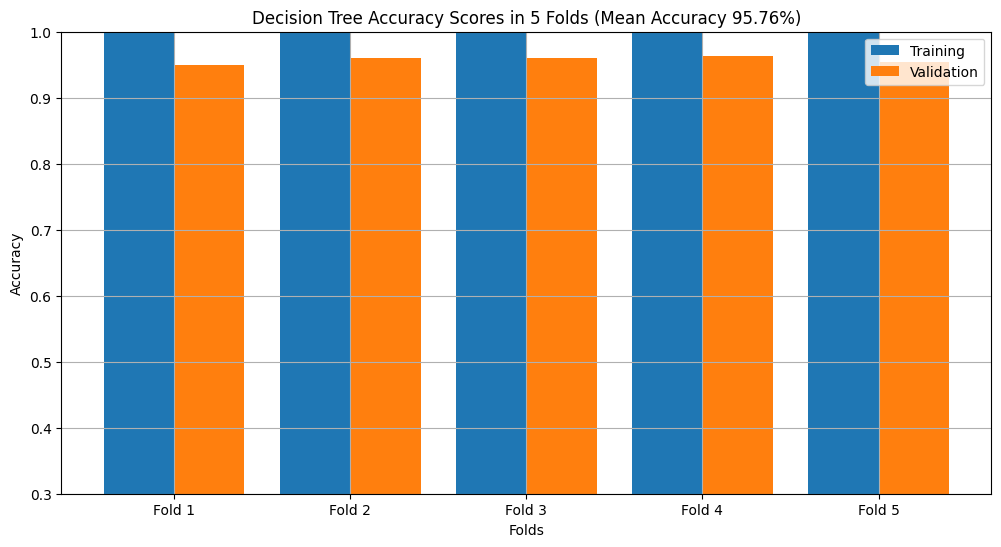

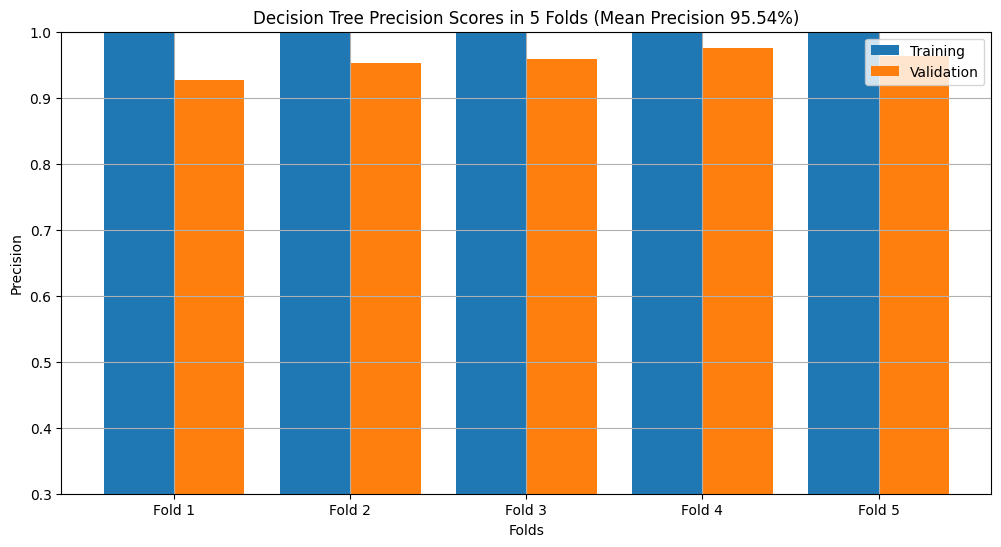

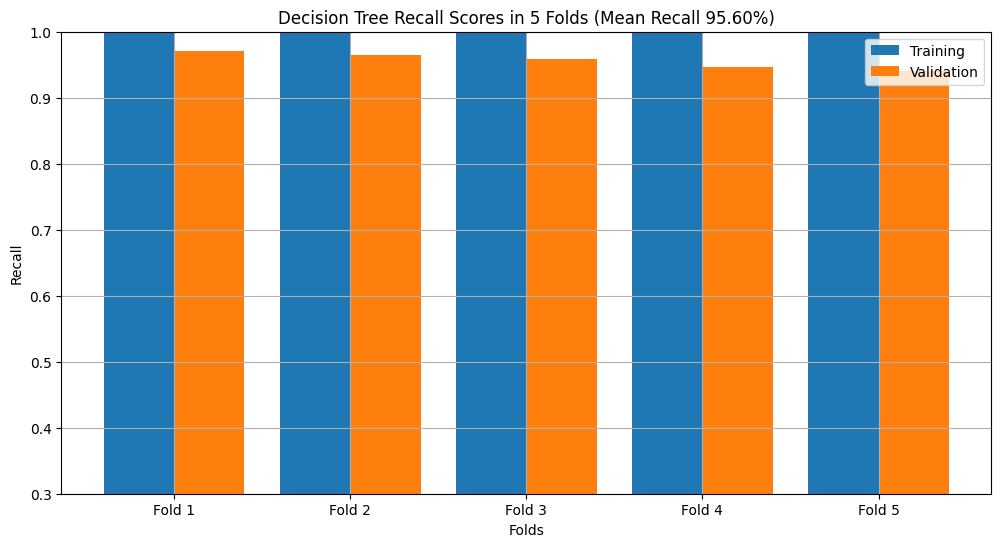

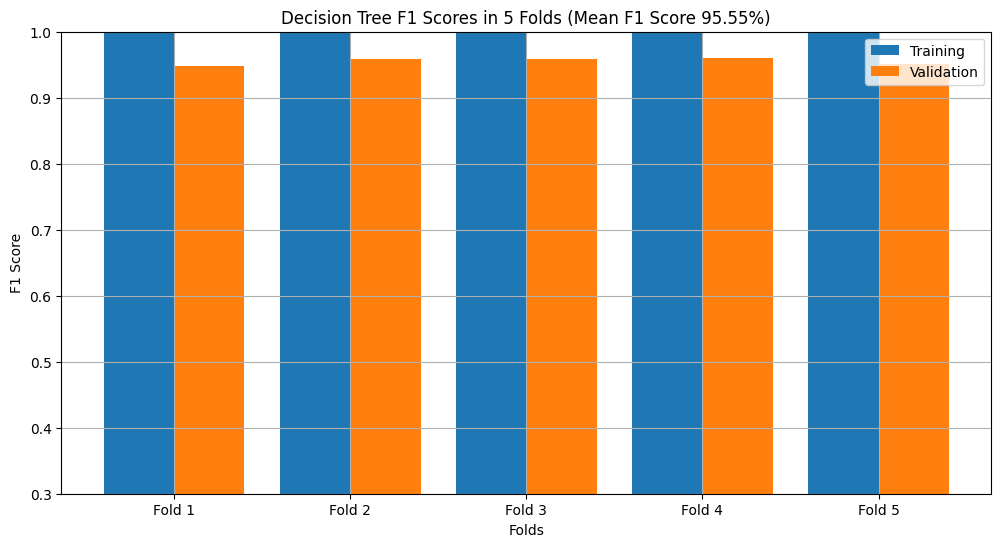

Random Forest 

Training Accuracy scores: [1.         0.99929229 0.99929279 0.99929279 1.        ]
Mean Training Accuracy: 99.95755717518978
Training Precision scores: [1.         1.         1.         0.99851852 1.        ]
Mean Training Precision: 0.9997037037037038
Training Recall scores: [1.         0.99851412 0.99851632 1.         1.        ]
Mean Training Recall: 0.9994060872747476
Training F1 scores: [1.         0.99925651 0.99925761 0.99925871 1.        ]
Mean Training F1 Score: 0.9995545650468955
Validation Accuracy scores: [0.96610169 0.96610169 0.96600567 0.95750708 0.9490085 ]
Mean Validation Accuracy: 96.09449272578864
Validation Precision scores: [0.95906433 0.95375723 0.96987952 0.96932515 0.94642857]
Mean Validation Precision: 0.9596909591587999
Validation Recall scores: [0.9704142  0.97633136 0.95833333 0.94047619 0.94642857]
Mean Validation Recall: 0.9583967314736546
Validation F1 scores: [0.96470588 0.96491228 0.96407186 0.95468278 0.94642857]
Mean Validation F1 Scor

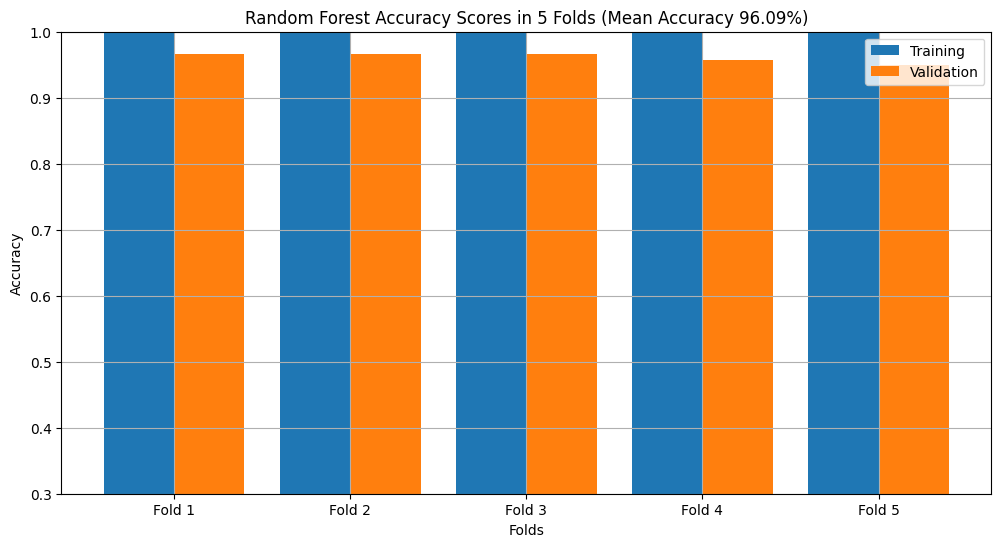

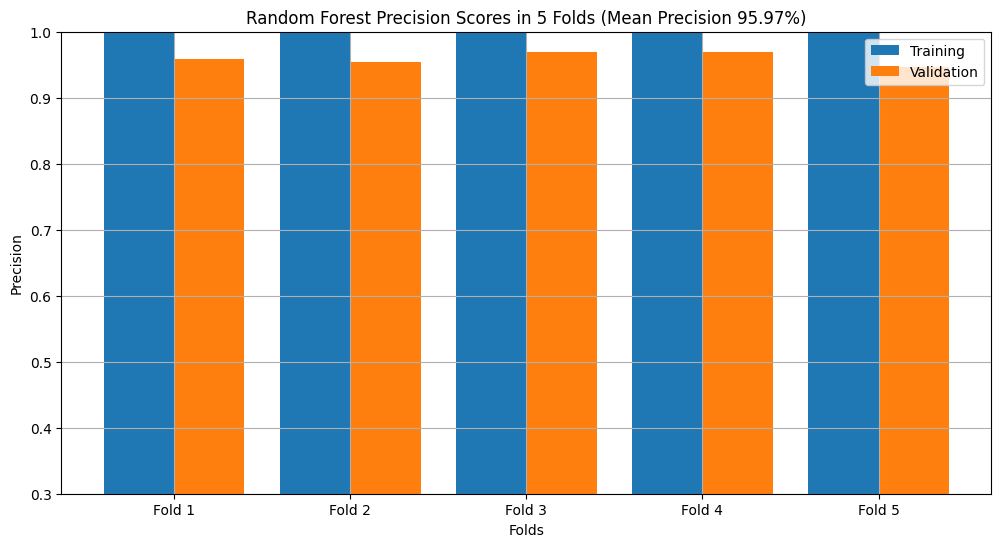

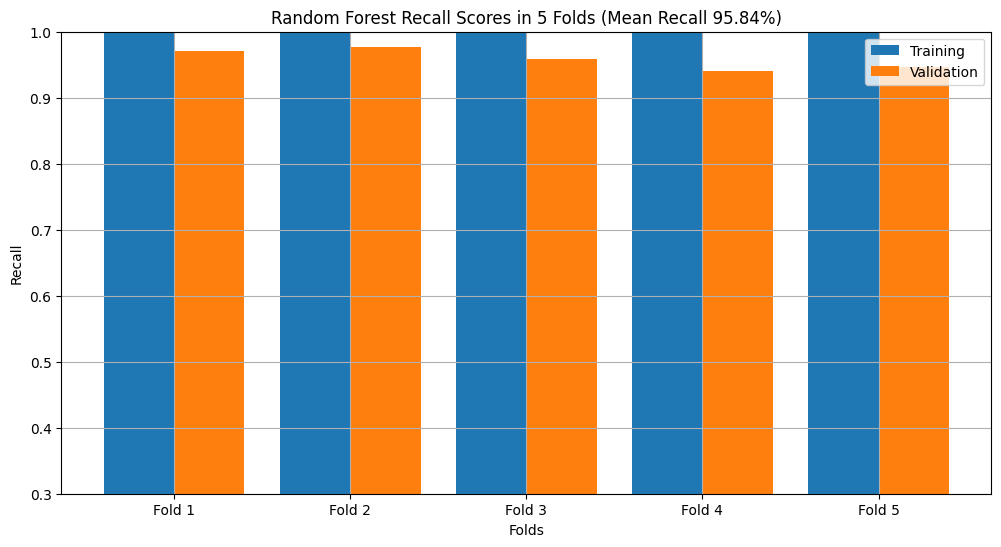

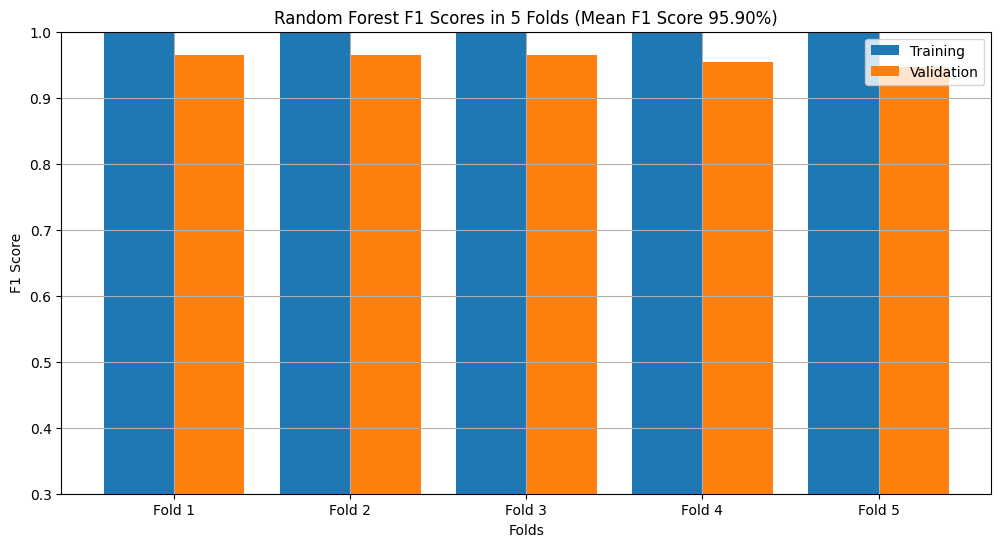

Logistic Regression 

Training Accuracy scores: [0.96602972 0.96602972 0.97029703 0.97029703 0.97100424]
Mean Training Accuracy: 96.87315501340854
Training Precision scores: [0.96433878 0.9671151  0.98318043 0.98170732 0.97451274]
Mean Training Precision: 0.9741708735141781
Training Recall scores: [0.96433878 0.96136701 0.95400593 0.95548961 0.96439169]
Mean Training Recall: 0.9599186070608153
Training F1 scores: [0.96433878 0.96423249 0.96837349 0.96842105 0.9694258 ]
Mean Training F1 Score: 0.9669583237291478
Validation Accuracy scores: [0.97740113 0.97740113 0.9631728  0.96033994 0.9631728 ]
Mean Validation Accuracy: 96.82975624589875
Validation Precision scores: [0.97076023 0.96531792 0.97546012 0.98125    0.96969697]
Mean Validation Precision: 0.9724970490779258
Validation Recall scores: [0.98224852 0.98816568 0.94642857 0.93452381 0.95238095]
Mean Validation Recall: 0.9607495069033531
Validation F1 scores: [0.97647059 0.97660819 0.96072508 0.95731707 0.96096096]
Mean Validation F

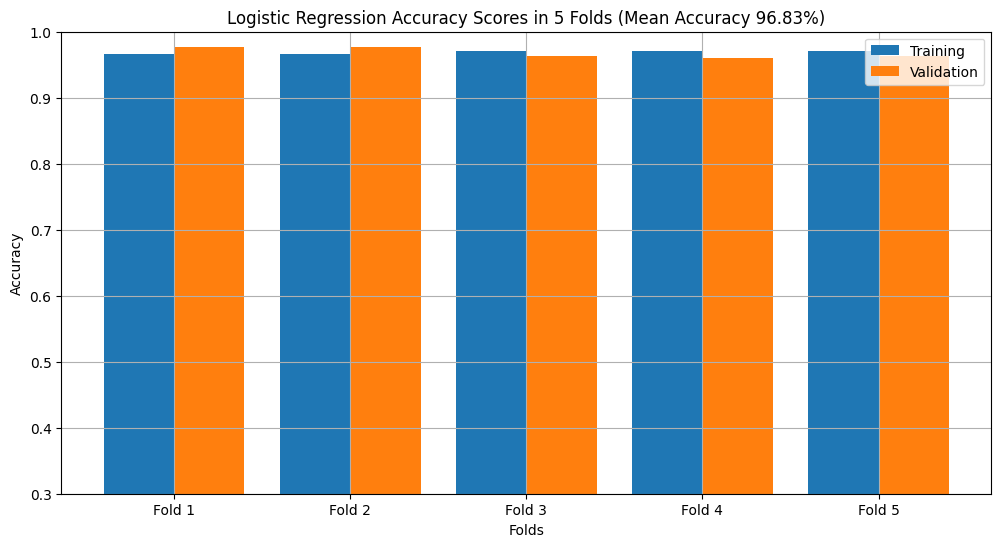

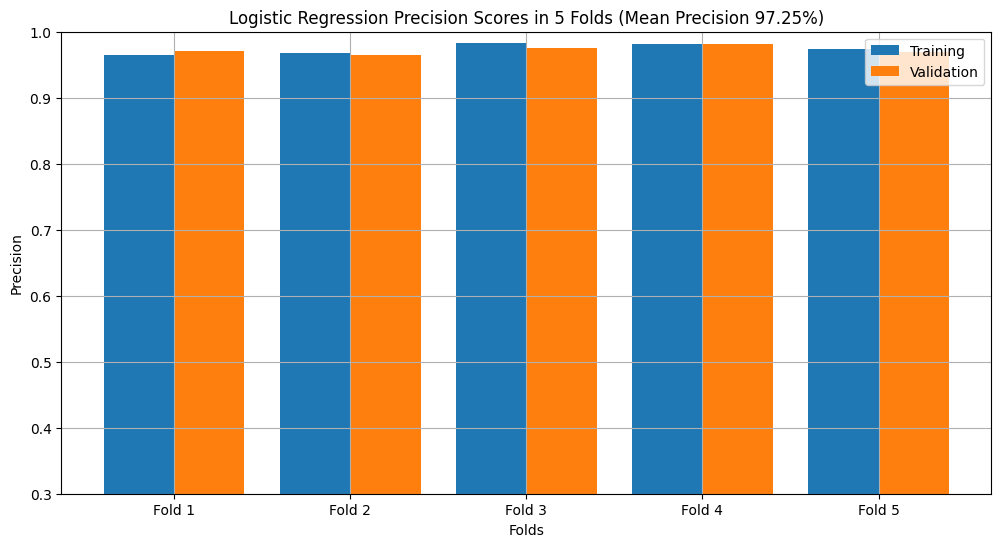

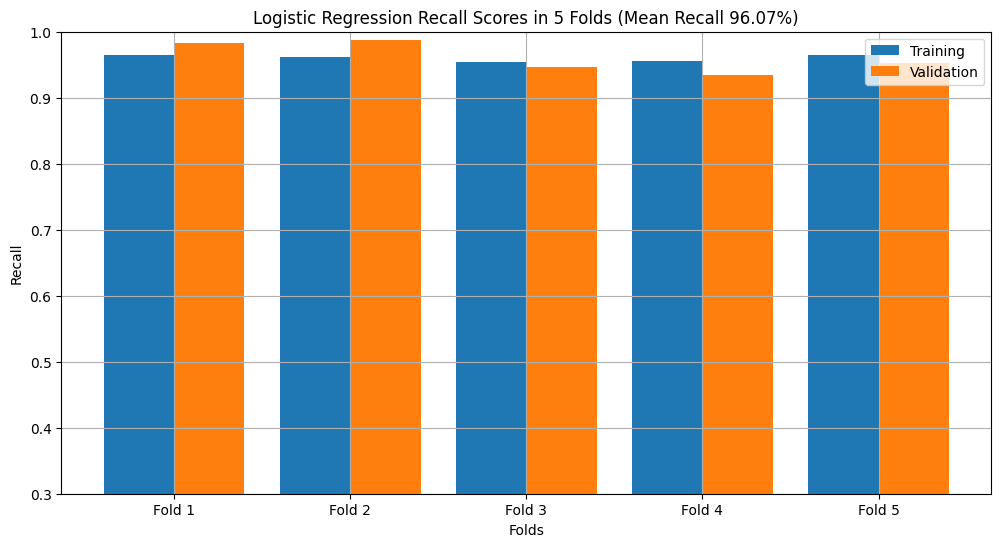

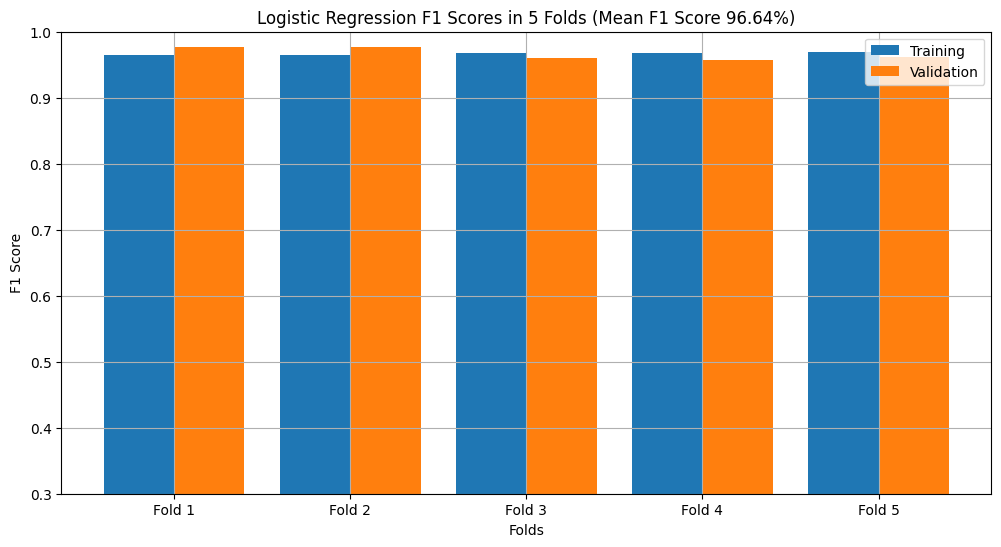

Multilayer Perceptron 

Training Accuracy scores: [0.96602972 0.96744515 0.97029703 0.97029703 0.97100424]
Mean Training Accuracy: 96.90146357674895
Training Precision scores: [0.96296296 0.96860987 0.97447447 0.98318043 0.97451274]
Mean Training Precision: 0.9727480949342064
Training Recall scores: [0.96582467 0.9628529  0.96290801 0.95400593 0.96439169]
Mean Training Recall: 0.9619966402264539
Training F1 scores: [0.96439169 0.9657228  0.96865672 0.96837349 0.9694258 ]
Mean Training F1 Score: 0.9673141010434829
Validation Accuracy scores: [0.97740113 0.97457627 0.96600567 0.95750708 0.96033994]
Mean Validation Accuracy: 96.71660184696147
Validation Precision scores: [0.97076023 0.96511628 0.96428571 0.97515528 0.9695122 ]
Mean Validation Precision: 0.9689659403797334
Validation Recall scores: [0.98224852 0.98224852 0.96428571 0.93452381 0.94642857]
Mean Validation Recall: 0.9619470273316427
Validation F1 scores: [0.97647059 0.97360704 0.96428571 0.95440729 0.95783133]
Mean Validation

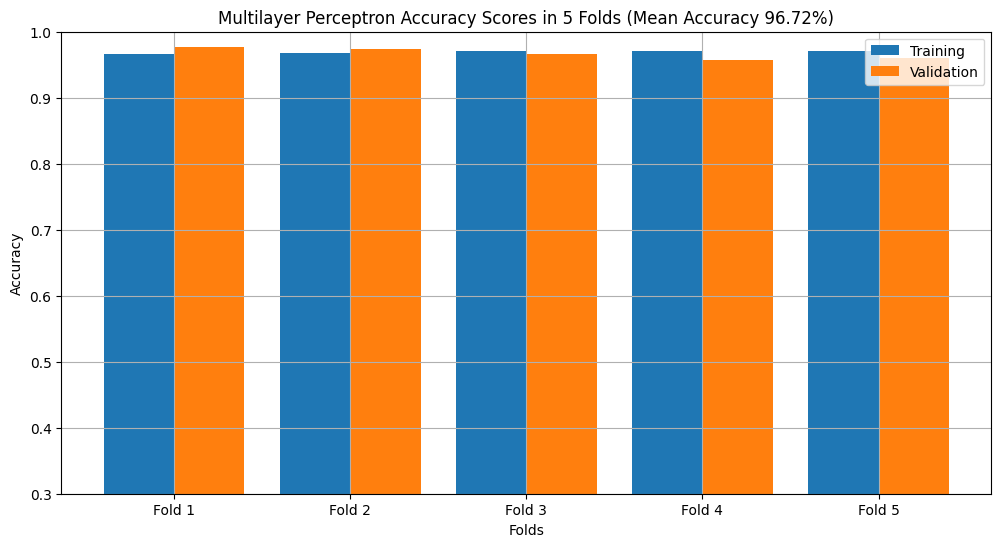

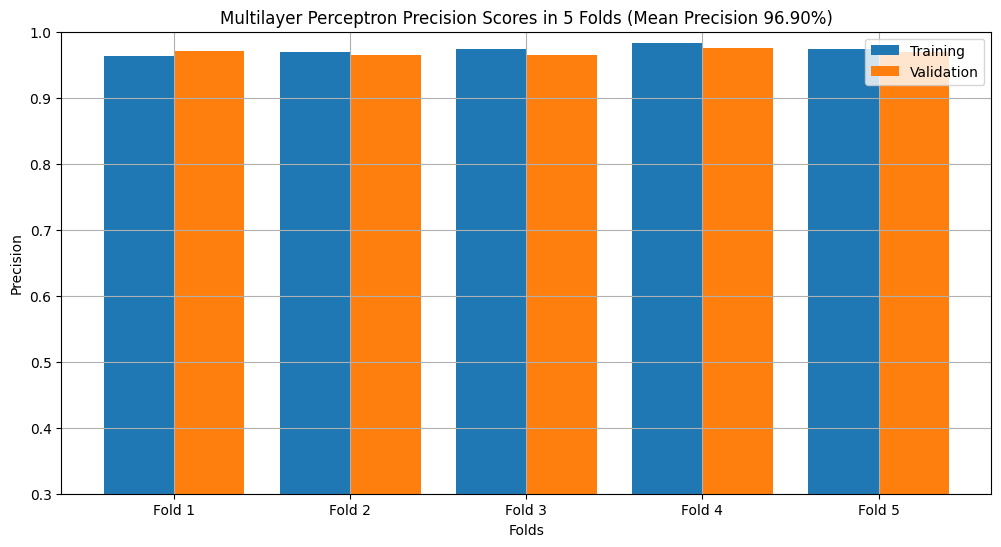

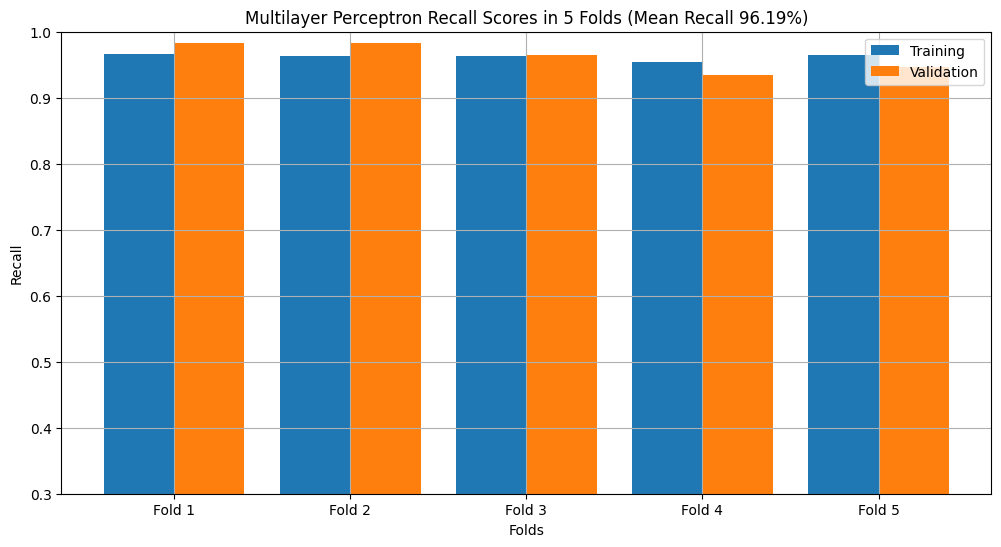

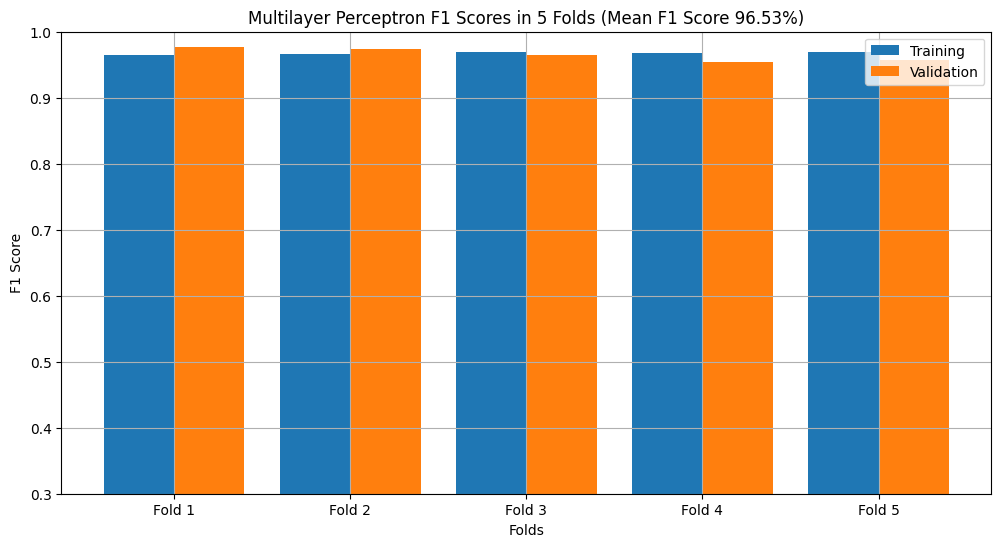

Support Vector Machines 

Training Accuracy scores: [0.95187544 0.96319887 0.96463932 0.96746818 0.96958982]
Mean Training Accuracy: 96.33543245134341
Training Precision scores: [0.91044776 0.94805195 0.98447205 0.98159509 0.97730711]
Mean Training Precision: 0.9603747922797377
Training Recall scores: [0.99702823 0.97622585 0.94065282 0.9495549  0.95845697]
Mean Training Recall: 0.9643837549217155
Training F1 scores: [0.95177305 0.96193265 0.96206373 0.9653092  0.96779026]
Mean Training F1 Score: 0.9617737790845758
Validation Accuracy scores: [0.94350282 0.97457627 0.9631728  0.95467422 0.95184136]
Mean Validation Accuracy: 95.75534962628639
Validation Precision scores: [0.89839572 0.9494382  0.98136646 0.98101266 0.97484277]
Mean Validation Precision: 0.9570111618646198
Validation Recall scores: [0.99408284 1.         0.94047619 0.92261905 0.92261905]
Mean Validation Recall: 0.9559594251901944
Validation F1 scores: [0.94382022 0.9740634  0.96048632 0.95092025 0.94801223]
Mean Validati

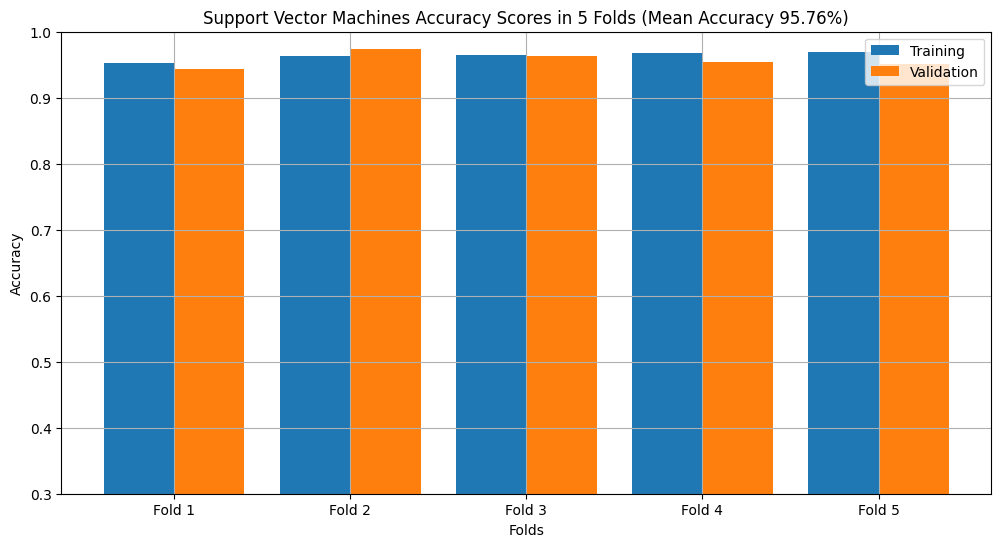

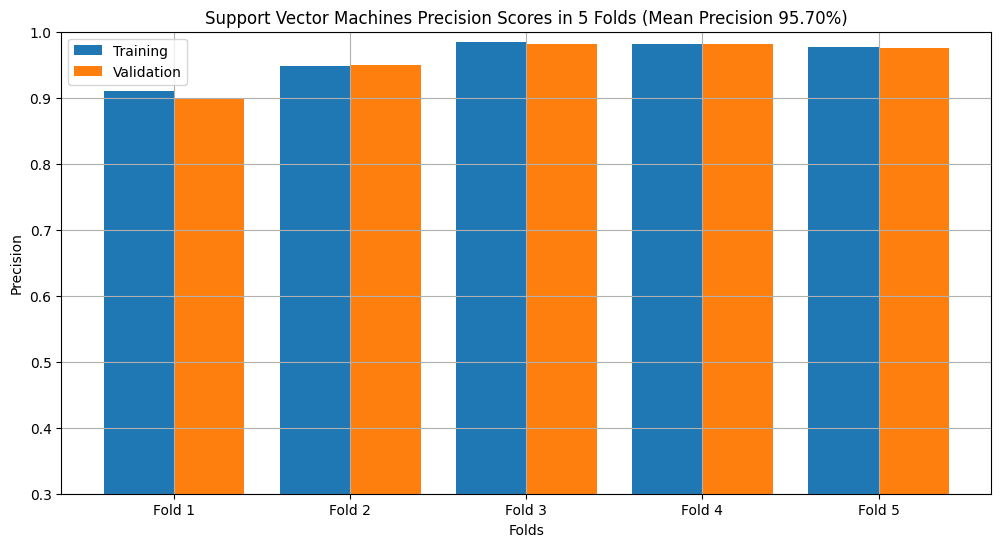

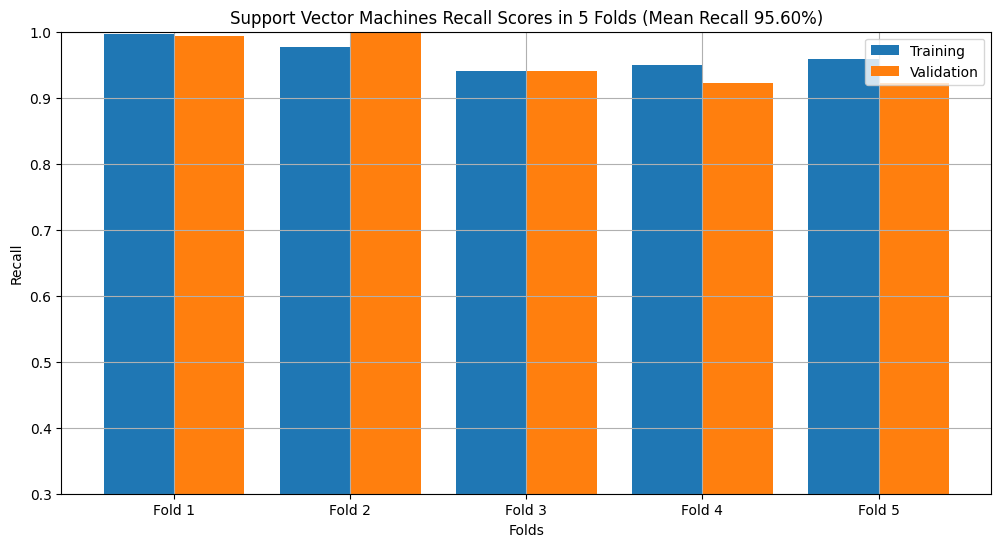

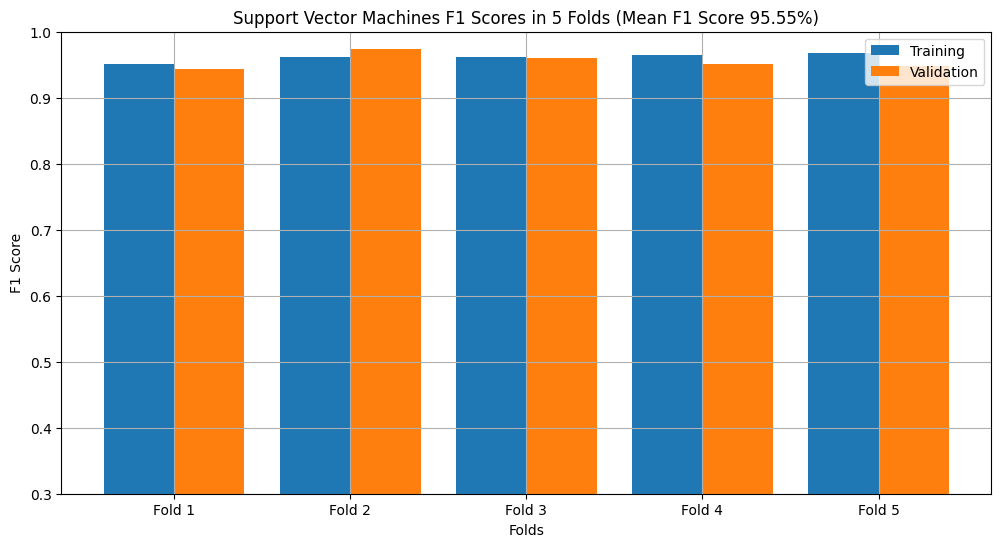

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machines" : SVC(),
}

for model_name, model in models.items():
    model_training_result = cross_validation(model, x, encoded_y, 5)

    print(model_name, "\n")
    for key in model_training_result:
        value = model_training_result[key]
        print(F"{key}: {value}")

    plot_result(
        model_name,
        "Accuracy",
        "Accuracy Scores in 5 Folds",
        model_training_result["Training Accuracy scores"],
        model_training_result["Validation Accuracy scores"],
        model_training_result["Mean Validation Accuracy"]/100
    )

    plot_result(
        model_name,
        "Precision",
        "Precision Scores in 5 Folds",
        model_training_result["Training Precision scores"],
        model_training_result["Validation Precision scores"],
        model_training_result["Mean Validation Precision"]
    )

    plot_result(
        model_name,
        "Recall",
        "Recall Scores in 5 Folds",
        model_training_result["Training Recall scores"],
        model_training_result["Validation Recall scores"],
        model_training_result["Mean Validation Recall"]
    )

    plot_result(
        model_name,
        "F1 Score",
        "F1 Scores in 5 Folds",
        model_training_result["Training F1 scores"],
        model_training_result["Validation F1 scores"],
        model_training_result["Mean Validation F1 Score"]
    )

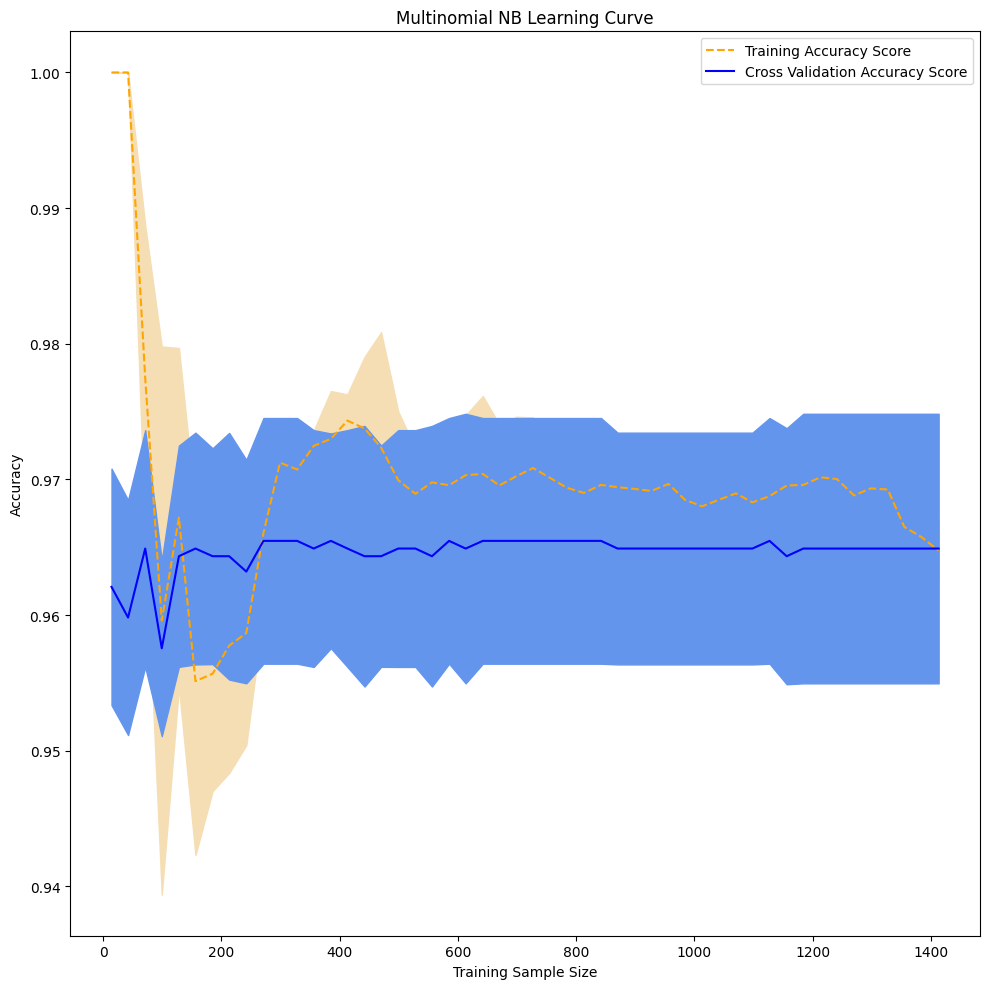

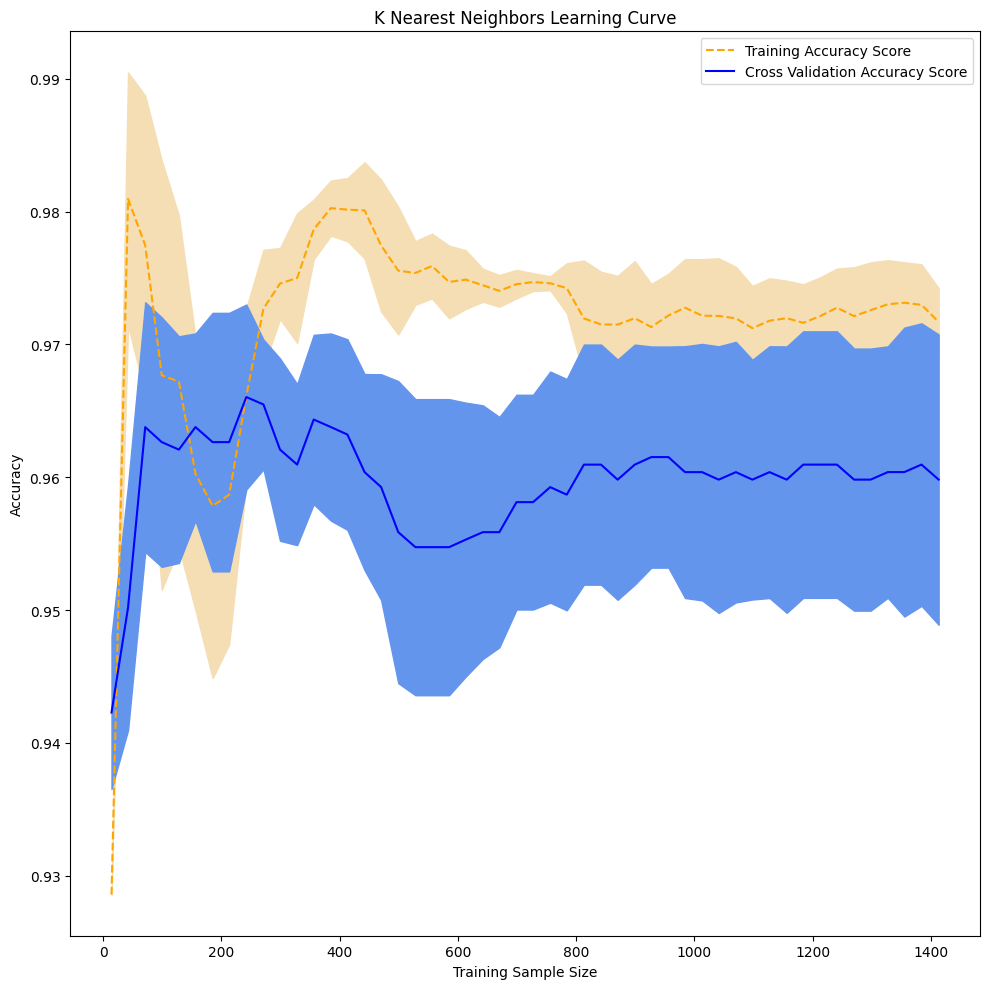

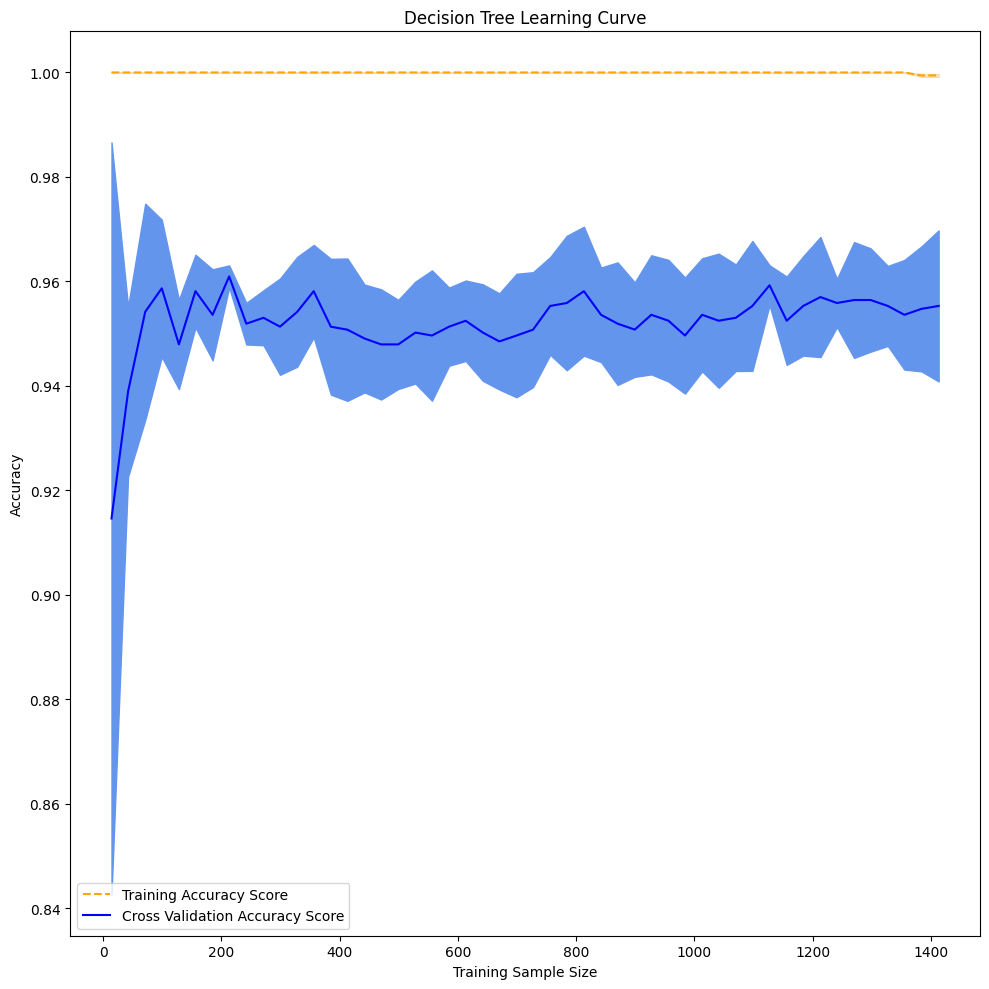

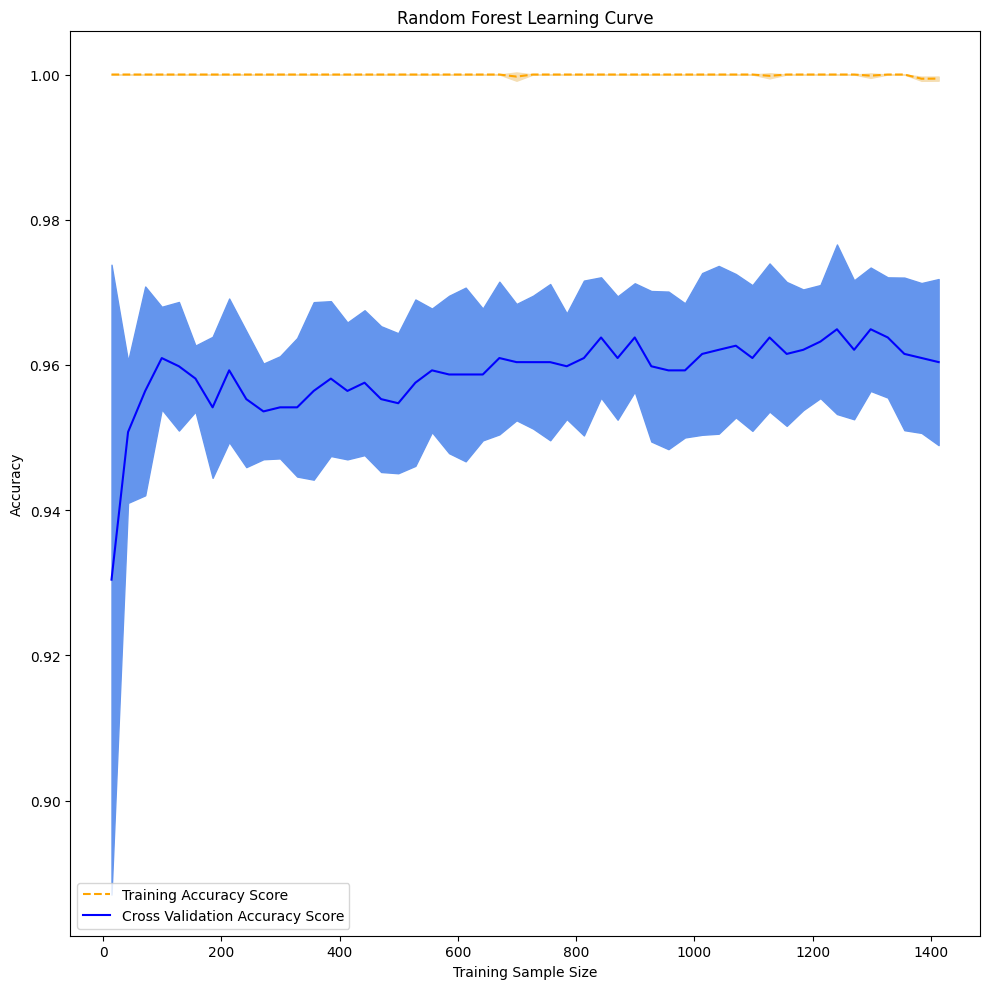

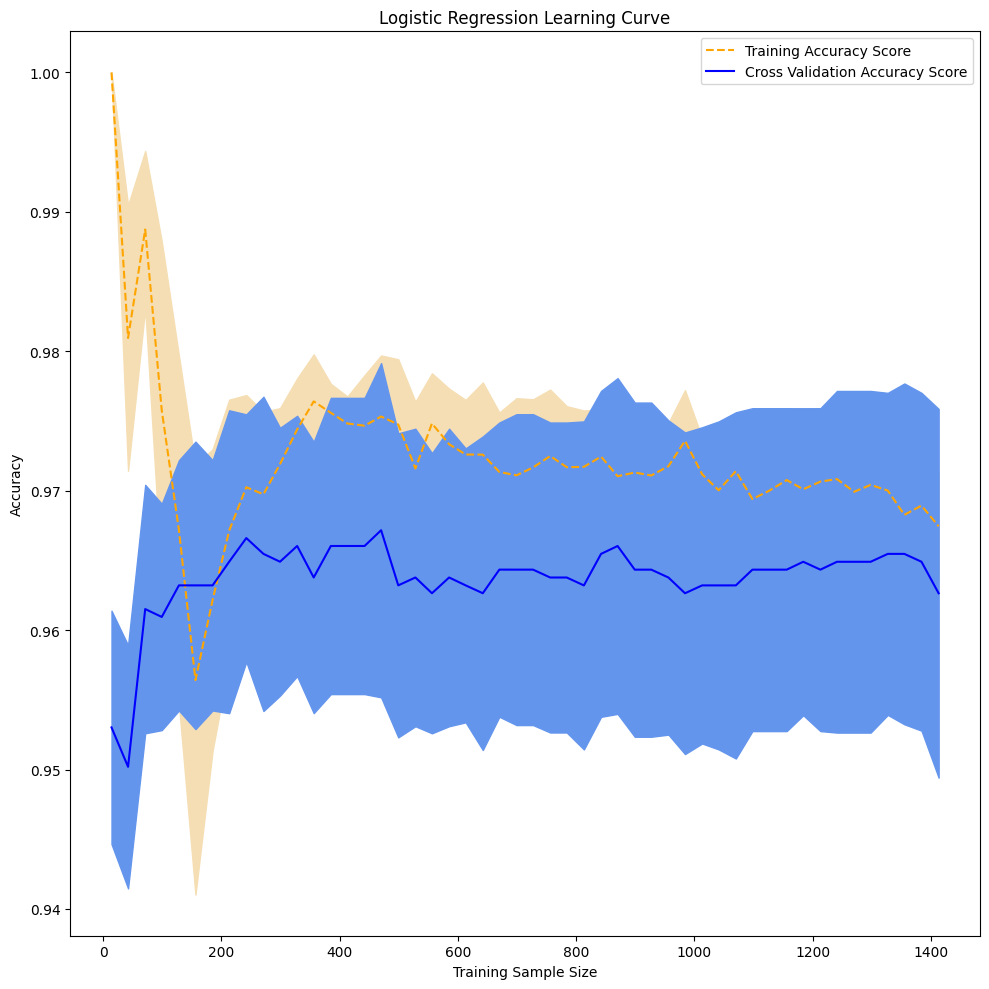

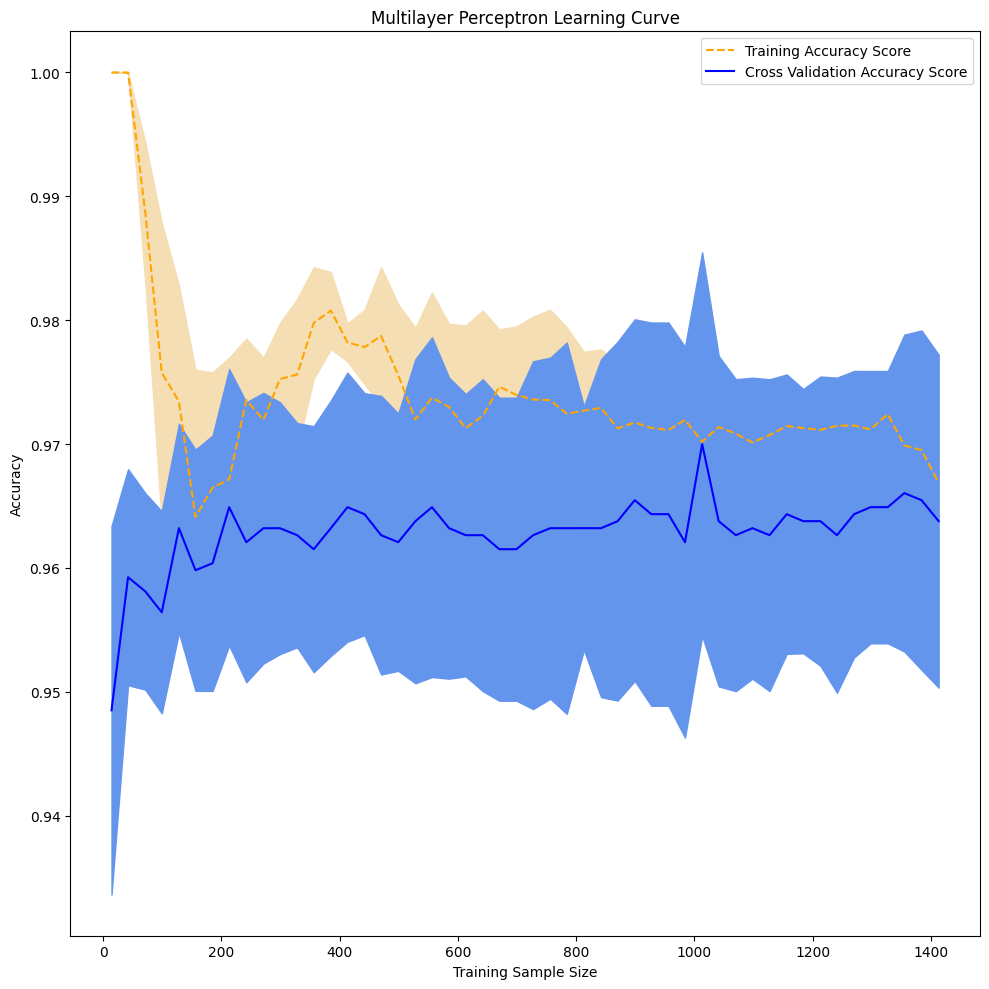

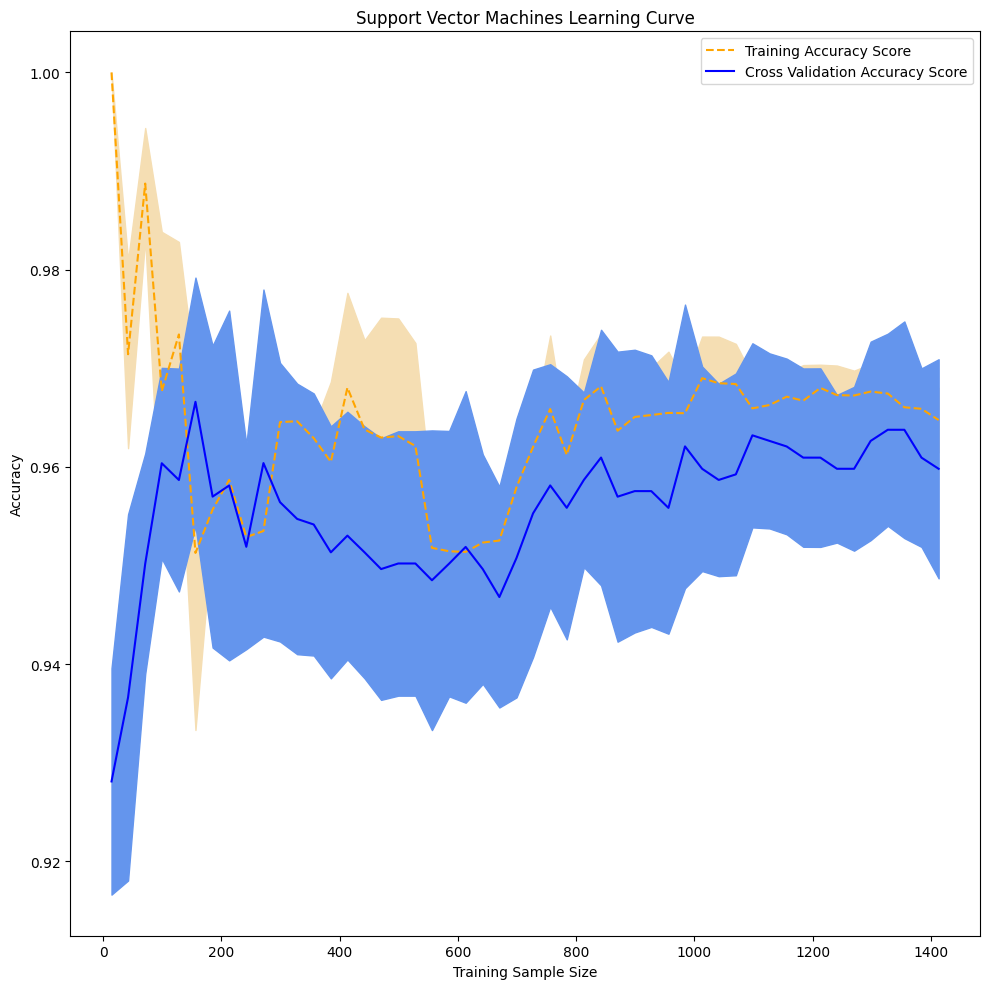

In [13]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machines" : SVC(),
}

for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
    plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

    plt.title(F"{model_name} Learning Curve")
    plt.xlabel("Training Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

    plt.show()